# The Relation Between Runs and Wins

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting_utils import plot_regression

sns.set_theme(style='darkgrid', palette='deep')

## Load Data

Teams win by outscoring opponents. Exploring this relationship using MLB data from 2001-2024.

Data source: [Lahman Baseball Database](https://sabr.org/lahman-database/)

In [2]:
teams = pd.read_csv('../data/lahman/Teams.csv')

## The Teams Table

The Lahman database contains team statistics dating back to 1871. This notebook 
focuses on seasons from 2001-2024 to analyze modern baseball. The covid 2020 shortened season was not included as only 60 games were played.

Key variables:
- `W`, `L` - Wins and losses
- `R`, `RA` - Runs scored and runs allowed
- `G` - Games played

In [3]:
teams.tail(3)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
3581,2024,AL,TEX,TEX,W,3,162,81.0,78,84,...,106.0,0.987,Texas Rangers,Globe Life Field,2651553.0,96.0,96.0,TEX,TEX,TEX
3582,2024,AL,TOR,TOR,E,5,162,81.0,74,88,...,125.0,0.984,Toronto Blue Jays,Rogers Centre,2681236.0,103.0,103.0,TOR,TOR,TOR
3583,2024,NL,WAS,WSN,E,4,162,81.0,71,91,...,155.0,0.981,Washington Nationals,Nationals Park,1967302.0,96.0,98.0,WSN,MON,WAS


Filter to recent seasons and extract key variables:
- **R**: Runs scored
- **RA**: Runs allowed
- **W/L**: Wins and losses

In [4]:
my_teams = teams.loc[(teams['yearID'] > 2000) & (teams['yearID'] != 2020), ['teamID', 'name', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0


### Creating Key Metrics

**Run Differential (RD)**: The difference between runs scored and runs allowed. 
Teams that outscore opponents have positive run differentials.

**Winning Percentage (Wpct)**: Fraction of games won. In a 162-game season, 
a .500 team wins 81 games.

In [5]:
my_teams['RD'] = my_teams['R'] - my_teams['RA']
my_teams['Wpct'] = my_teams['W'] / (my_teams['W'] + my_teams['L'])
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA,RD,Wpct
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0,-39.0,0.462963
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0,141.0,0.567901
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0,86.0,0.543210
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0,-142.0,0.391304
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0,27.0,0.509317


## Linear Regression:

$$Wpct = a + b \times RD + \epsilon$$


Plot relationship between **Run Differential (RD)** and **Winning Percentage (Wpct)** for 2001-2024 seasons

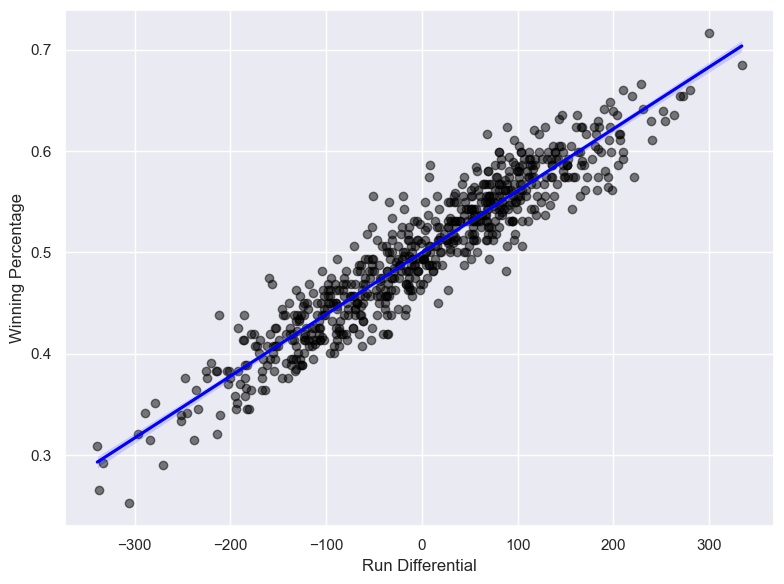

In [6]:
plot_regression(data=my_teams, x='RD', y='Wpct', xlabel='Run Differential', ylabel='Winning Percentage')
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression model
X = my_teams[['RD']].values
y = my_teams['Wpct'].values

linfit = LinearRegression()
linfit.fit(X, y)

# Display coefficients
intercept = linfit.intercept_
slope = linfit.coef_[0]

print(f"Intercept (a): {intercept:.6f}")
print(f"Slope (b): {slope:.6f}")
print(f"Equation: Wpct = {intercept:.6f} + {slope:.6f} * RD")

Intercept (a): 0.499991
Slope (b): 0.000610
Equation: Wpct = 0.499991 + 0.000610 * RD


### Interpreting the Linear Model

The model estimates:
- **Intercept ≈ 0.500**: A team with RD=0 is expected to win half its games
- **Slope ≈ 0.000610**: Each additional run of differential increases winning 
  percentage by 0.000610

**Practical interpretation**: In a 162-game season, a 10-run improvement in 
run differential corresponds to approximately one additional win 
(0.000610 × 10 × 162 ≈ 1 win).

In [8]:
from sklearn.metrics import root_mean_squared_error

# Calculate predictions and residuals
my_teams['predicted_Wpct'] = linfit.predict(X)
my_teams['residuals'] = my_teams['Wpct'] - my_teams['predicted_Wpct']

# Calculate R-squared
r_squared = linfit.score(X, y)
print(f"R-squared: {r_squared:.4f}")

# Calculate RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y, my_teams['predicted_Wpct'])
print(f"RMSE: {rmse:.4f}")
print(f"This means predictions are accurate within about {rmse*100:.1f} percentage points")

R-squared: 0.8885
RMSE: 0.0251
This means predictions are accurate within about 2.5 percentage points


### Understanding Residuals

**Residuals** measure prediction error which is the difference between actual and 
predicted winning percentage. Large positive residuals indicate teams that 
won more than expected and large negative residuals indicate underperformers.

We calculate RMSE (Root Mean Square Error) to measure average prediction error.

In [9]:
# View some examples with predictions and residuals
my_teams[['name', 'yearID', 'W', 'L', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']].sample(10)

,name,yearID,W,L,RD,Wpct,predicted_Wpct,residuals
3109,Chicago Cubs,2009,83,78,35.0,0.515528,0.521338,-0.005810
3261,Cleveland Indians,2014,85,77,16.0,0.524691,0.509750,0.014942
3534,Houston Astros,2023,90,72,129.0,0.555556,0.578669,-0.023113
3256,Baltimore Orioles,2014,96,66,112.0,0.592593,0.568300,0.024292
3120,Minnesota Twins,2009,87,76,52.0,0.533742,0.531706,0.002036
3582,Toronto Blue Jays,2024,74,88,-72.0,0.456790,0.456078,0.000712
3125,Pittsburgh Pirates,2009,62,99,-132.0,0.385093,0.419484,-0.034391
3580,Tampa Bay Rays,2024,80,82,-59.0,0.493827,0.464007,0.029820
3181,New York Yankees,2011,97,65,210.0,0.598765,0.628071,-0.029305
3102,Toronto Blue Jays,2008,86,76,104.0,0.530864,0.563421,-0.032557


### Residual Plot

Figure 4.2 displays a plot of the residuals against the run differential. We'll highlight the 6 teams with the largest residuals.

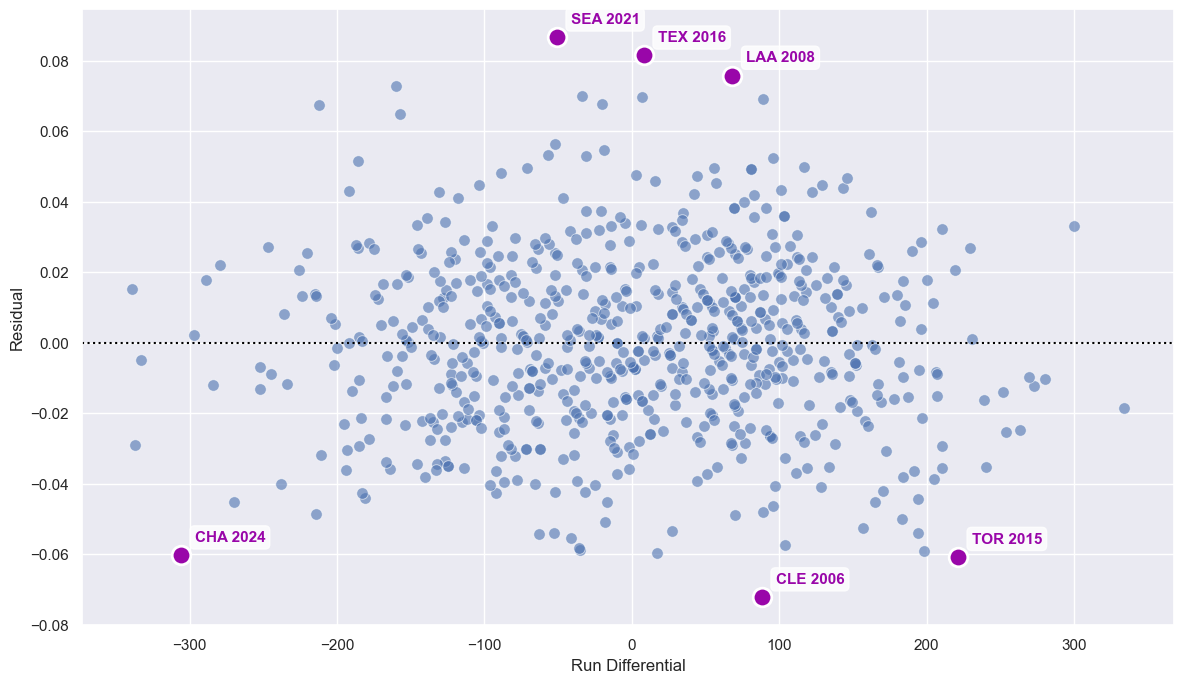

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=my_teams, x='RD', y='residuals', alpha=0.6, color='#4C72B0', s=70, ax=ax)
ax.axhline(y=0, linestyle=':', color='black', linewidth=1.5)
ax.set_xlabel('Run Differential', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)

# Find 3 highest residuals and 3 lowest residual
top_3 = my_teams.nlargest(3, 'residuals')
bottom_3 = my_teams.nsmallest(3, 'residuals')
outlier_teams = pd.concat([top_3, bottom_3])

# Highlight and label these teams
for _, row in outlier_teams.iterrows():
    ax.scatter(row['RD'], row['residuals'], color='#9906A9', s=180, zorder=5, edgecolors='white', linewidth=2)
    ax.annotate(f"{row['teamID']} {int(row['yearID'])}", 
               xy=(row['RD'], row['residuals']),
               xytext=(10, 10), 
               textcoords='offset points',
               color="#9906A9", 
               fontsize=11,
               fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [11]:
outlier_teams[['teamID', 'name', 'yearID', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']]

,teamID,name,yearID,RD,Wpct,predicted_Wpct,residuals
3487,SEA,Seattle Mariners,2021,-51.0,0.555556,0.468886,0.086669
3341,TEX,Texas Rangers,2016,8.0,0.586420,0.504871,0.081549
3087,LAA,Los Angeles Angels of Anaheim,2008,68.0,0.617284,0.541465,0.075819
3021,CLE,Cleveland Indians,2006,88.0,0.481481,0.553663,-0.072181
3312,TOR,Toronto Blue Jays,2015,221.0,0.574074,0.634780,-0.060706
3558,CHA,Chicago White Sox,2024,-306.0,0.253086,0.313361,-0.060275


Residuals show how far each team's actual winning percentage differs from the model's prediction. Teams furthest from the zero line had the biggest prediction errors.


### The Pythagorean Formula for Winning Percentage

Bill James developed the Pythagorean expectation to estimate winning percentage using runs scored and runs allowed. Unlike the linear model, this formula provides a ratio-based approach.

$$\widehat{Wpct} = \frac{R^2}{R^2 + RA^2}$$

In [19]:
#create Wpct_pt column to the my_teams dataframe
my_teams['Wpct_pyt'] = my_teams['R'] ** 2 / (my_teams['R'] ** 2 + my_teams['RA'] ** 2)

#create residuals_pyt column to my_teams dataframe for difference between actual and predicted winning percentages
my_teams['residuals_pyt'] = my_teams['Wpct'] - my_teams['Wpct_pyt']

In [24]:
# Calculate RMSE for Pythagorean predictions
rmse_pyt = np.sqrt((my_teams['residuals_pyt'] ** 2).mean())
print(f"RMSE (Pythagorean): {rmse_pyt:.4f}")

RMSE (Pythagorean): 0.0261


### Comparing the Models

The Pythagorean formula is slightly less accurate (RMSE: 0.0261 vs 0.0251), but it has a key advantage: it always produces valid winning percentages between 0 and 1.

The linear model can predict winning percentages above 1.0 or below 0 for extreme teams, which is impossible. This matters for:
- Historically dominant or terrible teams (2001 Mariners, 2024 White Sox, etc.)
- Hypothetical scenarios when evaluating player value

For most teams the models perform similarly, but the Pythagorean formula does a better job at handling extreme outlier cases
